# PCA de importações de Santos

## Setup

### Importações

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import glob

In [55]:
dict_dtypes = pd.read_pickle("datasets/aux_carga_dtypes.pkl").to_dict()

In [56]:
df = pd.read_csv("datasets/df_rus_ua_psantos.csv", decimal=",", dtype=dict_dtypes)

### Limpeza

In [57]:
df.columns

Index(['IDCarga', 'IDAtracacao', 'Origem', 'Destino', 'CDMercadoria',
       'Tipo Operação da Carga', 'Carga Geral Acondicionamento',
       'ConteinerEstado', 'Tipo Navegação', 'FlagAutorizacao', 'FlagCabotagem',
       'FlagCabotagemMovimentacao', 'FlagConteinerTamanho', 'FlagLongoCurso',
       'FlagMCOperacaoCarga', 'FlagOffshore', 'FlagTransporteViaInterioir',
       'Percurso Transporte em vias Interiores',
       'Percurso Transporte Interiores', 'STNaturezaCarga', 'STSH2', 'STSH4',
       'Natureza da Carga', 'Sentido', 'TEU', 'QTCarga', 'VLPesoCargaBruta',
       'Ano'],
      dtype='object')

In [28]:
df.drop(["IDAtracacao", "Destino", "Sentido"], axis=1, inplace=True)

### Junção de Carga com Carga Conteinerizada

In [29]:
def criar_mestre() -> pd.DataFrame:
    global df
    df_mestre = df.copy()
    for ano in range(df["Ano"].min(), df["Ano"].max() + 1):
        print("Ano atual: ", ano)
        df_cont = pd.read_csv(f"/home/vortex/Documents/Fatec/Trabalhos/Projeto Integrador local/BD/ANTAQ/{ano}Carga_Conteinerizada.csv", sep=";", decimal=",", dtype=dict_dtypes)

        df_mestre = df_mestre.merge(df_cont,"left", "IDCarga")

        # Combinação
        df_mestre["VLPesoCargaBruta"] = df_mestre["VLPesoCargaConteinerizada"].combine_first(df_mestre["VLPesoCargaBruta"])
        df_mestre.drop("VLPesoCargaConteinerizada", axis=1, inplace=True)
        df_mestre["CDMercadoria"] = df_mestre["CDMercadoriaConteinerizada"].combine_first(df_mestre["CDMercadoria"])
        df_mestre.drop("CDMercadoriaConteinerizada", axis=1, inplace=True)
    del df_cont
    del df
    return df_mestre

In [30]:
arq = "local_df_mestre.csv"
if glob.glob(arq):
    df_mestre = pd.read_csv(arq, dtype=dict_dtypes)
    print(f"{arq} carregado!")
else:
    df_mestre = criar_mestre()
    df_mestre.to_csv(arq, index=False)
    print(f"{arq} criado!")

local_df_mestre.csv carregado!


### Categorização

In [31]:
df_cat = df_mestre.copy()

In [32]:
for col in df_cat:
    if df_cat[col].dtype == "category":
        df_cat[col] = df_cat[col].cat.codes
    if df_cat[col].dtype == "object":
        df_cat[col] = df_cat[col].astype("category").cat.codes

In [33]:
df_cat["ConteinerEstado"].unique()

array([-1,  0], dtype=int8)

In [34]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10786 entries, 0 to 10785
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   IDCarga                                 10786 non-null  int64  
 1   IDAtracacao                             10786 non-null  int64  
 2   Origem                                  10786 non-null  int8   
 3   Destino                                 10786 non-null  int8   
 4   CDMercadoria                            10786 non-null  int16  
 5   Tipo Operação da Carga                  10786 non-null  int8   
 6   Carga Geral Acondicionamento            10786 non-null  int8   
 7   ConteinerEstado                         10786 non-null  int8   
 8   Tipo Navegação                          10786 non-null  int8   
 9   FlagAutorizacao                         10786 non-null  int8   
 10  FlagCabotagem                           10786 non-null  bo

In [35]:
df_cat.drop("IDCarga",axis=1, inplace=True)

In [36]:
df_cat = df_cat.fillna(0)

### Normalização dos dados

In [37]:
normalizador = StandardScaler()

In [38]:
arr_cat_norm = normalizador.fit_transform(df_cat)

## PCA

### Estimador e projeção

In [39]:
pca = PCA()

In [40]:
df_proj = pd.DataFrame(pca.fit_transform(arr_cat_norm), columns=pca.get_feature_names_out())

### Influência nas colunas do PCA

In [41]:
df_comp = pd.DataFrame(pca.components_, pca.get_feature_names_out(), df_cat.columns)

Maior influência em pca0

In [42]:
df_comp.abs().sort_values(by="pca0", axis=1, ascending=False).head(3)

,ConteinerEstado,Natureza da Carga,Carga Geral Acondicionamento,FlagConteinerTamanho,IDAtracacao,Ano,TEU,VLPesoCargaBruta,CDMercadoria,STSH2,...,FlagAutorizacao,FlagCabotagemMovimentacao,FlagLongoCurso,FlagMCOperacaoCarga,Percurso Transporte Interiores,Sentido,FlagTransporteViaInterioir,FlagOffshore,FlagCabotagem,Percurso Transporte em vias Interiores
pca0,0.423641,0.421404,0.416990,0.406206,0.300782,0.290285,0.206562,0.187065,0.152718,0.110208,...,2.646978e-23,5.169879e-26,2.524355e-29,7.888609e-31,0.0,0.0,0.0,0.0,0.000000e+00,0.0
pca1,0.042388,0.039181,0.029180,0.048550,0.039113,0.033757,0.010928,0.016332,0.039588,0.596948,...,2.168404e-19,0.000000e+00,1.323489e-23,8.271806e-25,0.0,0.0,0.0,0.0,2.710505e-20,0.0
pca2,0.121073,0.133700,0.150395,0.111278,0.581535,0.595049,0.074940,0.291906,0.132408,0.009263,...,3.469447e-18,2.168404e-19,3.388132e-21,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0


Logo, "ConteinerEstado" é redundante!

Maior influência em pca1

In [43]:
df_comp.abs().sort_values(by="pca1", axis=1, ascending=False).head(2)

,STSH2,STNaturezaCarga,STSH4,FlagConteinerTamanho,ConteinerEstado,CDMercadoria,Natureza da Carga,IDAtracacao,QTCarga,Origem,...,FlagAutorizacao,FlagCabotagem,FlagLongoCurso,FlagMCOperacaoCarga,FlagCabotagemMovimentacao,FlagOffshore,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,Sentido
pca0,0.110208,0.060701,0.020243,0.406206,0.423641,0.152718,0.421404,0.300782,0.041152,0.091937,...,2.646978e-23,0.000000e+00,2.524355e-29,7.888609e-31,5.169879e-26,0.0,0.0,0.0,0.0,0.0
pca1,0.596948,0.577567,0.543898,0.048550,0.042388,0.039588,0.039181,0.039113,0.037363,0.037347,...,2.168404e-19,2.710505e-20,1.323489e-23,8.271806e-25,0.000000e+00,0.0,0.0,0.0,0.0,0.0


Mais influênciado por "Ano"

In [44]:
df_comp.abs().sort_values(by="Ano", axis=0, ascending=False).head(3)

,IDAtracacao,Origem,Destino,CDMercadoria,Tipo Operação da Carga,Carga Geral Acondicionamento,ConteinerEstado,Tipo Navegação,FlagAutorizacao,FlagCabotagem,...,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,Sentido,TEU,QTCarga,VLPesoCargaBruta,Ano
pca13,0.710073,0.008666,1.665335e-16,0.000830,0.000937,0.054323,0.076056,9.540979e-18,2.255141e-17,2.428613e-17,...,0.0,0.057723,0.051171,0.002444,0.048626,0.0,0.000323,0.008229,0.002236,0.691802
pca2,0.581535,0.235822,1.110223e-16,0.132408,0.214615,0.150395,0.121073,6.938894e-18,3.469447e-18,0.000000e+00,...,0.0,0.077833,0.009263,0.098821,0.133700,0.0,0.074940,0.119412,0.291906,0.595049
pca0,0.300782,0.091937,5.551115e-17,0.152718,0.044245,0.416990,0.423641,4.235165e-22,2.646978e-23,0.000000e+00,...,0.0,0.060701,0.110208,0.020243,0.421404,0.0,0.206562,0.041152,0.187065,0.290285


In [45]:
df_mestre["ConteinerEstado"].unique()

[NaN, 'Cheio']
Categories (1, object): ['Cheio']

## Plotagem

### Por natureza

In [46]:
df_mestre["Natureza da Carga"].unique().tolist()

['Granel Sólido',
 'Carga Conteinerizada',
 'Carga Geral',
 'Granel Líquido e Gasoso']

In [47]:
x_col = "Natureza da Carga"

In [48]:
x_estilos = {
    'Granel Sólido': ('#1f77b4', 'o'),
    'Carga Conteinerizada': ('#ff7f0e', 's'),
    'Carga Geral': ('#2ca02c', 'v'),
    'Granel Líquido e Gasoso': ('#d62728', '^')
}

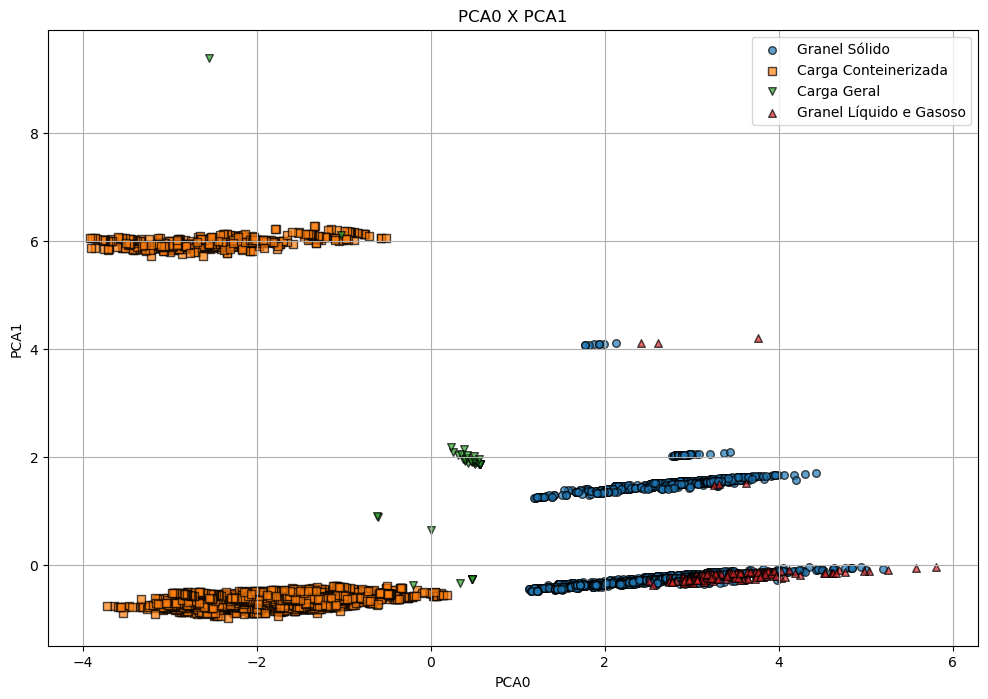

In [49]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_proj[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend()
plt.show()

Em teoria se eu tirar esses indicadores, isso ainda vai ser um padrão dos dados!

### Por pais

In [50]:
df_mestre["Origem"].unique().tolist()

['RU006',
 'RULED',
 'RUNVS',
 'UAILK',
 'UAODS',
 'RUTUA',
 'UAYUZ',
 'RUKRR',
 'RUZZZ',
 'RUMMK',
 'RUKGD',
 'RUPRI',
 'RUVVO',
 'RUKAV']

In [51]:
x_col = "Origem"

In [52]:
x_feature = "STSH2"

In [53]:
x_estilos = {
    'RU Exclusivo': ('#1f77b4', 'o'),
    'RU Compartilhado': ('#aaff14', '^'),
}

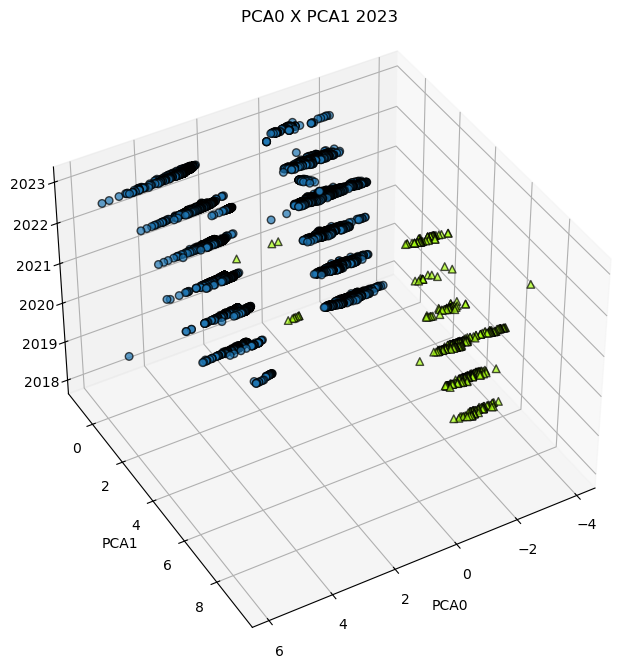

In [63]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection="3d")
for ano in range(2018, 2023 + 1):
    plt.title(f"PCA0 X PCA1 {ano}")
    plt.xlabel("PCA0")
    plt.ylabel("PCA1")
    plt.grid(True)

    # Plotar os dados
    for x_, (cor, marker) in x_estilos.items():
        subset = df_proj[(df_mestre[x_col].str[:2] == x_.split(' ')[0]) & (df_mestre[x_feature] == x_.split(' ')[1]) & (df_mestre["Ano"] == ano)]
        ax.scatter(subset['pca0'], subset['pca1'], ano, marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

# plt.legend(title="Ano")
ax.view_init(azim=60, elev=40)
plt.show()

Difícil interpretar!